# Neural ODE with Train/Validation Split

This notebook demonstrates a neural ODE approach to learning pulse dynamics from the CUORE experiment.

## Key Concept:
- **Training**: Model learns to predict pulse shapes given their peak energies (20 pulses)
- **Validation Approach**: The trained model should be able to generate pulse shapes given only energy values
- The model learns the relationship: Peak Energy → Pulse Dynamics

## How it works:
1. Each pulse has initial conditions `[0, energy, 0]` where the middle value is the peak energy
2. The neural ODE learns: `dy/dt = f(t, y)` where `f` is a neural network
3. Given just the energy value, the model should generate the complete pulse shape


In [1]:
import jax
import jaxlib

print("JAX version:", jax.__version__)
print("JAXLIB version:", jaxlib.__version__)
print("Available devices:", jax.devices())

from jax.lib import xla_bridge
print("Backend platform:", xla_bridge.get_backend().platform)


JAX version: 0.4.35
JAXLIB version: 0.4.35
Available devices: [CpuDevice(id=0)]
Backend platform: cpu


/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_44814/3439237912.py:9: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print("Backend platform:", xla_bridge.get_backend().platform)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot as up

tower2p1_events = pd.read_csv("pulse_out/Tower2p1_event_info.csv")
pulses_tower2p1 = up.concatenate(["pulse_out/Run352044_tower2p1.root:tree"], library='np')['samples']
event_nums_tower2p1 = up.concatenate(["pulse_out/Run352044_tower2p1.root:tree"], library='np')['event_number']

ADC2mV = 8.0108642578125e-02
CHANNEL = 60

# Load average pulse for normalization
file = open("average_pulse_dump/Channel00" + str(CHANNEL) + "_AveragePulse.txt")
for line in file:
    parse = line.replace("fData  ", "")
    parse = parse.replace("\n", "")
    splits = parse.split(" ")
    avg_pulse = np.array(splits, dtype=float)
    break

ch60_pulses = pulses_tower2p1[tower2p1_events['Channel']==60]
ch60_events = tower2p1_events[tower2p1_events['Channel']==60]

print(f"Total pulses available: {len(ch60_pulses)}")


Total pulses available: 1822


In [15]:
# Split into training and validation
n_train = 25
n_val = 25

# Prepare pulses
pulses_processed = []
max_val = -10000

for i in range(n_train + n_val):
    pulse = ch60_pulses[i][2920:]
    pulse = pulse + np.min(pulse)*-1
    pulses_processed.append(pulse)
    if np.min(pulse) < max_val:
        max_val = np.min(pulse)

pulses_processed = list(map(lambda arr: arr/max_val*-1, pulses_processed))

# Split into train and val
train_pulses = pulses_processed[:n_train]
val_pulses = pulses_processed[n_train:n_train+n_val]

print(f"Training pulses: {len(train_pulses)}")
print(f"Validation pulses: {len(val_pulses)}")


Training pulses: 25
Validation pulses: 25


In [16]:
times = np.linspace(-3, 7, 10000)
times = times[2920:]
length = len(train_pulses[0])

print(f"Time points: {len(times)}")
print(f"Pulse length: {length}")

import optax
import equinox as eqx
import jax
import jax.numpy as jnp
import diffrax

# Create initial conditions for training (with peak energies)
vars_train = []
for pulse in train_pulses:
    vars_train.append([0, 10*np.max(pulse), 0, 0])
vars_train = jnp.array(vars_train)

print("Training initial conditions:")
print(vars_train.shape)
print(vars_train)


Time points: 7080
Pulse length: 7080
Training initial conditions:
(25, 4)
[[ 0.     4.503  0.     0.   ]
 [ 0.     3.816  0.     0.   ]
 [ 0.     2.266  0.     0.   ]
 [ 0.     6.345  0.     0.   ]
 [ 0.     2.504  0.     0.   ]
 [ 0.     2.973  0.     0.   ]
 [ 0.     2.499  0.     0.   ]
 [ 0.     4.687  0.     0.   ]
 [ 0.     5.406  0.     0.   ]
 [ 0.     4.294  0.     0.   ]
 [ 0.     2.286  0.     0.   ]
 [ 0.     5.105  0.     0.   ]
 [ 0.     4.809  0.     0.   ]
 [ 0.     7.179  0.     0.   ]
 [ 0.     5.168  0.     0.   ]
 [ 0.     3.311  0.     0.   ]
 [ 0.     5.567  0.     0.   ]
 [ 0.    10.072  0.     0.   ]
 [ 0.     2.426  0.     0.   ]
 [ 0.     8.354  0.     0.   ]
 [ 0.     2.55   0.     0.   ]
 [ 0.     2.912  0.     0.   ]
 [ 0.     2.844  0.     0.   ]
 [ 0.     7.646  0.     0.   ]
 [ 0.     2.602  0.     0.   ]]


In [17]:
# NEW: Per-Pulse Energy-Aware Model
# Each pulse's dynamics depend on ITS energy

class PerPulseFunction(eqx.Module):
    """
    Model that processes each pulse independently based on its own energy and a latent.
    Input: (n, 5) where each row is [y1, y2, y3, energy, latent]
    Output: (n, 3) where each row is [dy1, dy2, dy3]
    """
    layers: list

    def __init__(self, key): 
        key1, key2, key3 = jax.random.split(key, 3)
        # Input: 5 (3 state vars + 1 energy + 1 latent)
        # Output: 3 (derivatives)
        self.layers = [
            eqx.nn.Linear(5, int(n_train*0.6), key=key1, use_bias=True), 
            eqx.nn.Linear(int(n_train*0.6), 3, key=key2, use_bias=True)
        ]
    
    def __call__(self, t, y_with_ctx, *args):
        # y_with_ctx shape: (n, 5) - [y1, y2, y3, energy, latent]
        derivatives = []
        for i in range(y_with_ctx.shape[0]):
            pulse_input = y_with_ctx[i]
            out = pulse_input
            for layer in self.layers[:-1]:
                out = jax.nn.tanh(layer(out))
            out_derivs = self.layers[-1](out)  # (3,)
            # Energy and latent are constants during evolution
            derivative_ext = jnp.concatenate([out_derivs, jnp.array([0.0, 0.0])])
            derivatives.append(derivative_ext)
        return jnp.array(derivatives)  # (n, 5)


In [18]:
# Create initial conditions WITH energy and latent in state vector for new model
vars_train_with_energy = []
for pulse in train_pulses:
    energy = 10*np.max(pulse)
    latent = 0.0  # placeholder latent per pulse
    # State is [y1, y2, y3, energy, latent]
    vars_train_with_energy.append([0, 0, 0, energy, latent])
vars_train_with_energy = jnp.array(vars_train_with_energy)

print("Initial conditions for per-pulse model:")
print(vars_train_with_energy.shape)  # Should be (n_train, 5)
print(vars_train_with_energy)

# Same for validation
vars_val_with_energy = []
for pulse in val_pulses:
    energy = 10*np.max(pulse)
    latent = 0.0
    vars_val_with_energy.append([0, 0, 0, energy, latent])
vars_val_with_energy = jnp.array(vars_val_with_energy)


Initial conditions for per-pulse model:
(25, 5)
[[ 0.     0.     0.     4.503  0.   ]
 [ 0.     0.     0.     3.816  0.   ]
 [ 0.     0.     0.     2.266  0.   ]
 [ 0.     0.     0.     6.345  0.   ]
 [ 0.     0.     0.     2.504  0.   ]
 [ 0.     0.     0.     2.973  0.   ]
 [ 0.     0.     0.     2.499  0.   ]
 [ 0.     0.     0.     4.687  0.   ]
 [ 0.     0.     0.     5.406  0.   ]
 [ 0.     0.     0.     4.294  0.   ]
 [ 0.     0.     0.     2.286  0.   ]
 [ 0.     0.     0.     5.105  0.   ]
 [ 0.     0.     0.     4.809  0.   ]
 [ 0.     0.     0.     7.179  0.   ]
 [ 0.     0.     0.     5.168  0.   ]
 [ 0.     0.     0.     3.311  0.   ]
 [ 0.     0.     0.     5.567  0.   ]
 [ 0.     0.     0.    10.072  0.   ]
 [ 0.     0.     0.     2.426  0.   ]
 [ 0.     0.     0.     8.354  0.   ]
 [ 0.     0.     0.     2.55   0.   ]
 [ 0.     0.     0.     2.912  0.   ]
 [ 0.     0.     0.     2.844  0.   ]
 [ 0.     0.     0.     7.646  0.   ]
 [ 0.     0.     0.     2.602  0.   ]]


In [19]:
def model_to_loss_per_pulse(model, y_all, t_s, vars_init):
    """
    Loss function for per-pulse energy-aware model.
    vars_init has shape (n, 4) - each pulse is [y1, y2, y3, energy]
    """
    t_s = jnp.array(t_s, dtype=jnp.float32)
    vars_jax = jnp.array(vars_init, dtype=jnp.float32)
    
    solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(model),
        diffrax.Tsit5(),
        t0=t_s[0],
        t1=t_s[-1],
        dt0=jnp.array(0.001, dtype=jnp.float32),
        y0=vars_jax,   
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )

    # Loss: compare predicted pulse shape (first component) to actual
    y_loss = 0 
    for i in range(len(y_all)):
        arr = solutions.ys[:len(solutions.ys), i]  # Shape: (time_steps, 4)
        # Extract first component: [dy1, dy2, dy3, energy] → y1
        y_pred = arr[:, 0]  # First component is the pulse shape
        # Note: arr has shape (time_steps, 4)
        # But we need to integrate to get actual values, so let's use the first component directly
        y_loss = y_loss + jnp.mean((y_pred - y_all[i][:len(arr)])**2)

    all_outputs = solutions.ys
   
    # Equilibrium loss: model should output zeros for zero input
    # zero_input should be (n, 4)
    zero_input = jnp.zeros_like(all_outputs[-1])  # Shape (n, 4)
    zero_output = model(0, zero_input)  # Should also return (n, 4)
    # Only check that derivatives are zero (first 3 components)
    equilibrium_loss = jnp.mean(jnp.abs(zero_output[:, :3]) ** 2)

    total_loss = (y_loss/len(y_all) + equilibrium_loss)
    return total_loss

model_to_loss_and_grad_per_pulse = eqx.filter_value_and_grad(model_to_loss_per_pulse)

def make_step_per_pulse(m, opt_s, y_all, t_s, vars_init):
    loss, grad = model_to_loss_and_grad_per_pulse(eqx.filter(m, eqx.is_inexact_array), 
                                                   y_all, t_s, vars_init)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss


In [20]:
# Initialize optimizer and random key
opt = optax.rmsprop(learning_rate=0.003)
key = jax.random.PRNGKey(41)
key, subkey = jax.random.split(key, 2)

print("Optimizer and random key initialized!")


Optimizer and random key initialized!


In [21]:
import sys
print("=" * 60)
print("TRAINING NEW PER-PULSE ENERGY-AWARE MODEL")
print("=" * 60)
opt = optax.rmsprop(learning_rate=0.003)
key = jax.random.PRNGKey(41)
key, subkey = jax.random.split(key, 2)

print("Optimizer and random key initialized!")

MODEL_PER_PULSE = PerPulseFunction(key)
best_loss_pp = float('inf')
opt_state_pp = opt.init(eqx.filter(MODEL_PER_PULSE, eqx.is_array))
loss_history_pp = []

# --- FIX: Store the best model in a variable ---
best_model_so_far = MODEL_PER_PULSE 
# -----------------------------------------------

print("Starting training...")
for epoch in range(4000):
    MODEL_PER_PULSE, opt_state_pp, loss = make_step_per_pulse(MODEL_PER_PULSE, opt_state_pp, 
                                                                train_pulses, times, 
                                                                vars_train_with_energy)
    loss_history_pp.append(loss)
    
    # Print every 10 epochs (so you can see progress)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

    if loss < best_loss_pp:
        best_loss_pp = loss
        # --- FIX: Don't save to disk, just update the variable ---
        best_model_so_far = MODEL_PER_PULSE
        # --------------------------------------------------------

# --- FIX: Save the single best model ONCE, after the loop ---
print(f"\nTraining complete. Best loss: {best_loss_pp}")
eqx.tree_serialise_leaves("best_model_per_pulse.eqx", best_model_so_far)
print("Best model saved to 'best_model_per_pulse.eqx'")

TRAINING NEW PER-PULSE ENERGY-AWARE MODEL
Optimizer and random key initialized!
Starting training...
Epoch 0, Loss: 0.2392909973859787
Epoch 10, Loss: 0.037732865661382675
Epoch 20, Loss: 0.07350411266088486
Epoch 30, Loss: 0.017680995166301727
Epoch 40, Loss: 0.02154216170310974
Epoch 50, Loss: 0.02055126614868641
Epoch 60, Loss: 0.01347055658698082
Epoch 70, Loss: 0.01494966447353363
Epoch 80, Loss: 0.0209684818983078
Epoch 90, Loss: 0.014241409488022327
Epoch 100, Loss: 0.012029684148728848
Epoch 110, Loss: 0.012443695217370987
Epoch 120, Loss: 0.013533472083508968
Epoch 130, Loss: 0.012750819325447083
Epoch 140, Loss: 0.011609900742769241
Epoch 150, Loss: 0.011278300546109676
Epoch 160, Loss: 0.011266039684414864
Epoch 170, Loss: 0.010916097089648247
Epoch 180, Loss: 0.01054942887276411
Epoch 190, Loss: 0.010350068099796772
Epoch 200, Loss: 0.010224942117929459
Epoch 210, Loss: 0.009964317083358765
Epoch 220, Loss: 0.00973588414490223
Epoch 230, Loss: 0.009588677436113358
Epoch 240

In [22]:
# TEST NEW MODEL ON VALIDATION
print("\n" + "=" * 60)
print("VALIDATION: NEW PER-PULSE MODEL")
print("=" * 60)

# Generate predictions for validation using new model
solutions_val_pp = diffrax.diffeqsolve(
    diffrax.ODETerm(MODEL_PER_PULSE),
    diffrax.Tsit5(),
    t0=times[0],
    t1=times[-1],
    dt0=jnp.array(0.001, dtype=jnp.float32),
    y0=vars_val_with_energy,   # Use validation energies
    stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
    saveat=diffrax.SaveAt(ts=jnp.sort(times)),
)

val_predictions_pp = []
for i in range(n_val):
    val_predictions_pp.append(solutions_val_pp.ys[:len(solutions_val_pp.ys), i][:, 0])

# Calculate validation loss
val_loss_pp = 0
for i in range(n_val):
    val_loss_pp += np.mean((val_predictions_pp[i] - val_pulses[i][:len(val_predictions_pp[0])])**2)
val_loss_pp = val_loss_pp / n_val

print(f"Validation Loss (MSE, New Model): {val_loss_pp:.6f}")
print(f"Training Loss (MSE proxy, min train objective): {best_loss_pp:.6f}")
print(f"Loss Ratio: {val_loss_pp/best_loss_pp:.2f}")
print("=" * 60)



VALIDATION: NEW PER-PULSE MODEL
Validation Loss (MSE, New Model): 0.000262
Training Loss (MSE proxy, min train objective): 0.000187
Loss Ratio: 1.40


In [23]:
import os
from datetime import datetime

# Create output directories with a unique run id
run_id = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
base_dir = os.path.join("outputs", "per_pulse", run_id)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Save validation plots: predicted vs actual
for i in range(n_val):
    y_pred = val_predictions_pp[i]
    y_true = val_pulses[i][:len(y_pred)]
    mse = float(np.mean((y_pred - y_true)**2))

    plt.figure(figsize=(4, 3))
    plt.plot(times[:len(y_pred)], y_true, label="Actual Val", linewidth=1.5, color="blue")
    plt.plot(times[:len(y_pred)], y_pred, label="Predicted", linewidth=1.5, linestyle="--", color="red")
    plt.title(f"Val {i+1} | E={vars_val_with_energy[i,3]:.2f} | MSE={mse:.4g}", fontsize=9)
    plt.legend(fontsize=7)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(val_dir, f"val_{i+1:03d}.png"), dpi=150)
    plt.close()

# Generate training predictions using the trained model
solutions_train_pp = diffrax.diffeqsolve(
    diffrax.ODETerm(MODEL_PER_PULSE),
    diffrax.Tsit5(),
    t0=times[0],
    t1=times[-1],
    dt0=jnp.array(0.001, dtype=jnp.float32),
    y0=vars_train_with_energy,
    stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
    saveat=diffrax.SaveAt(ts=jnp.sort(times)),
)

train_predictions_pp = []
for i in range(n_train):
    train_predictions_pp.append(solutions_train_pp.ys[:len(solutions_train_pp.ys), i][:, 0])

# Save training plots: predicted vs actual
for i in range(n_train):
    y_pred = train_predictions_pp[i]
    y_true = train_pulses[i][:len(y_pred)]
    mse = float(np.mean((y_pred - y_true)**2))

    plt.figure(figsize=(4, 3))
    plt.plot(times[:len(y_pred)], y_true, label="Actual Train", linewidth=1.5, color="blue")
    plt.plot(times[:len(y_pred)], y_pred, label="Predicted", linewidth=1.5, linestyle="--", color="red")
    plt.title(f"Train {i+1} | E={vars_train_with_energy[i,3]:.2f} | MSE={mse:.4g}", fontsize=9)
    plt.legend(fontsize=7)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(train_dir, f"train_{i+1:03d}.png"), dpi=150)
    plt.close()

print(f"Saved plots to: {base_dir}")


Saved plots to: outputs/per_pulse/2025-10-30_14-54-00


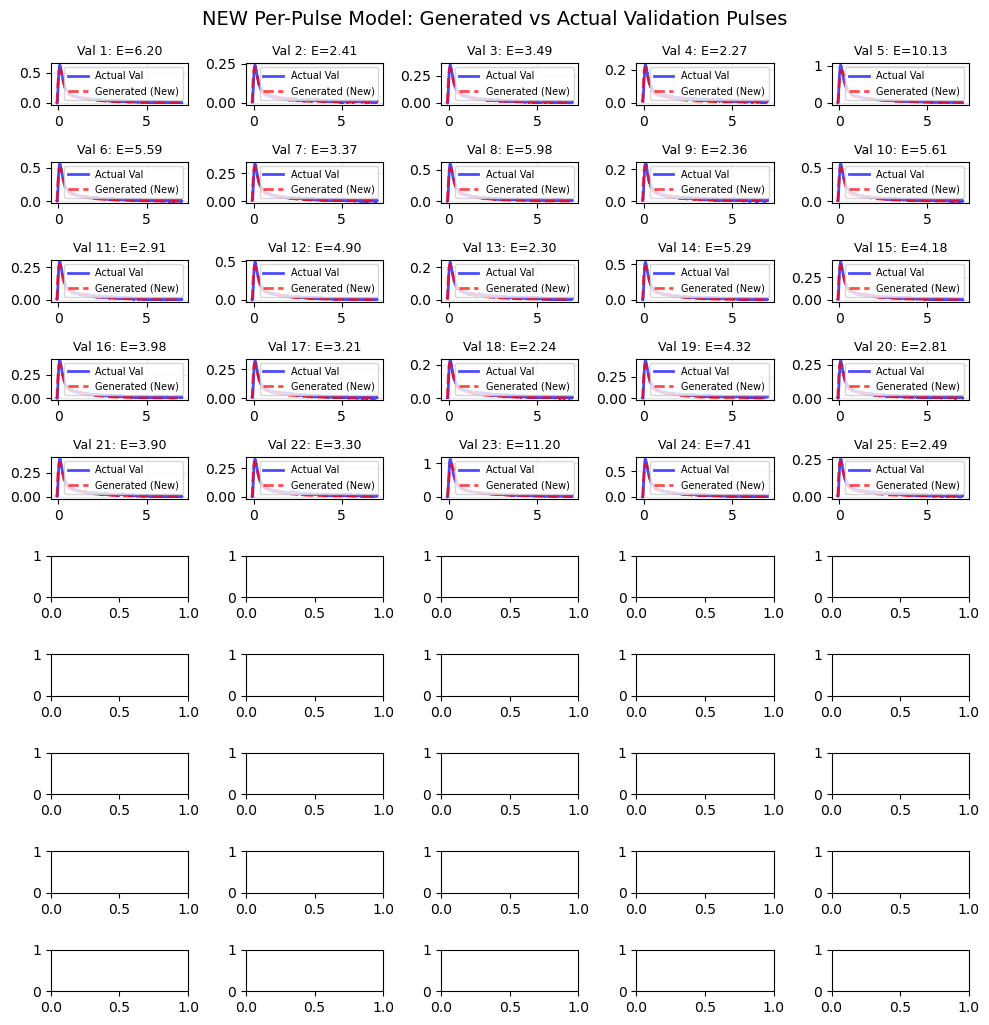


COMPARISON: Old Model vs New Per-Pulse Model


In [24]:
# Visualize NEW model validation results
fig, axes = plt.subplots(10, 5, figsize=(10, 10))
axes = axes.flatten()

for i in range(n_train):
    axes[i].plot(times, val_pulses[i], label='Actual Val', alpha=0.7, linewidth=2, color='blue')
    axes[i].plot(times, val_predictions_pp[i], label='Generated (New)', alpha=0.7, 
                 linewidth=2, linestyle='--', color='red')
    axes[i].set_title(f'Val {i+1}: E={vars_val_with_energy[i,3]:.2f}', fontsize=9)
    axes[i].legend(fontsize=7)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('NEW Per-Pulse Model: Generated vs Actual Validation Pulses', 
             fontsize=14, y=1.02)
plt.show()

# Compare old vs new model
print("\n" + "=" * 60)
print("COMPARISON: Old Model vs New Per-Pulse Model")
print("=" * 60)


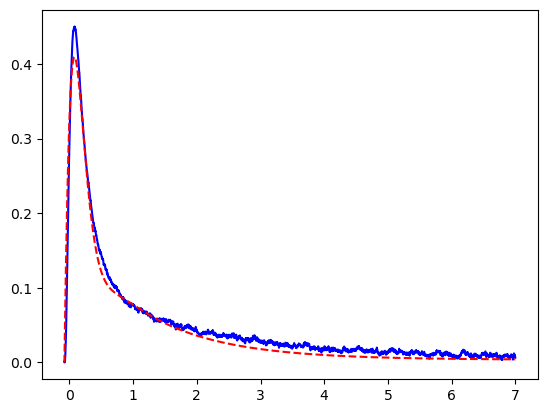

In [25]:

y_pred = train_predictions_pp[0]
y_true = train_pulses[0][:len(y_pred)]
plt.plot(times[:len(y_pred)], y_true, label="Actual Train", linewidth=1.5, color="blue")
plt.plot(times[:len(y_pred)], y_pred, label="Predicted", linewidth=1.5, linestyle="--", color="red")